## **0. Tải bộ dữ liệu**
**Lưu ý:** Nếu không thể tải bằng gdown do bị giới hạn số lượt tải, các bạn hãy tải thủ công và đưa lên drive của mình, sau đó copy từ drive vào colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [1]:
# https://drive.google.com/file/d/1f7WAwkuTFgLzCCTs2HZv3AmtBkET4l1M/view?usp=share_link
!gdown --id 1f7WAwkuTFgLzCCTs2HZv3AmtBkET4l1M

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1f7WAwkuTFgLzCCTs2HZv3AmtBkET4l1M
To: /content/sem_eval_2018.zip
100% 662k/662k [00:00<00:00, 163MB/s]


In [2]:
!unzip './sem_eval_2018.zip'

Archive:  ./sem_eval_2018.zip
   creating: sem_eval_2018/
  inflating: sem_eval_2018/val.csv   
  inflating: sem_eval_2018/test.csv  
  inflating: sem_eval_2018/train.csv  


## **1. Import các thư viện cần thiết**

In [3]:
!pip install unidecode tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 28.2 MB/s 
     |████████████████████████████████| 1.1 MB 27.0 MB/s 


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
import unidecode
import tensorflow_addons as tfa

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

RANDOM_SEED = 1
tf.random.set_seed(RANDOM_SEED)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **2. Chuẩn bị dữ liệu**

In [5]:
english_stop_words = stopwords.words('english') # Lấy danh sách stopwords từ thư viện ntlk
stemmer = PorterStemmer() # Khai báo stemmer object (dùng để stemming trong hàm normalize text)

# Xây dựng hàm text normalization
def text_normalize(text):
    text = text.lower() # Chuyển chữ viết thường 
    text = unidecode.unidecode(text) # Mã hóa về ASCII
    text = text.strip() # Xóa kí tự đặc biệt ở đầu và cuối string
    text = re.sub(r'[^\w\s]', '', text) # Loại bỏ dấu câu
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words]) # Xóa stopwords
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')]) # Stemming
 
    return text

In [6]:
BATCH_SIZE = 128
MAX_SEQ_LEN = 128
MAX_FEATURES = 5000 
EMBEDDING_DIMS = 64

ROOT_FOLDER_PATH = './sem_eval_2018'

train_filepath = os.path.join(ROOT_FOLDER_PATH, 'train.csv')
val_filepath = os.path.join(ROOT_FOLDER_PATH, 'val.csv')
test_filepath = os.path.join(ROOT_FOLDER_PATH, 'test.csv')

train_df = pd.read_csv(train_filepath, 
                index_col=0) 
val_df = pd.read_csv(val_filepath, 
                index_col=0) 
test_df = pd.read_csv(test_filepath, 
                index_col=0) 

train_df['Tweet'] = train_df['Tweet'].apply(lambda p: text_normalize(p)).astype(str) 
val_df['Tweet'] = val_df['Tweet'].apply(lambda p: text_normalize(p)).astype(str) 
test_df['Tweet'] = test_df['Tweet'].apply(lambda p: text_normalize(p)).astype(str) 

class_lst = np.array(train_df.columns[2:])
n_classes = len(class_lst)

X_train, y_train = train_df['Tweet'].to_numpy(), train_df[class_lst].astype('int').to_numpy()
X_val, y_val = val_df['Tweet'].to_numpy(), val_df[class_lst].astype('int').to_numpy()
X_test, y_test = test_df['Tweet'].to_numpy(), test_df[class_lst].astype('int').to_numpy()

In [7]:
train_df

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,worri payment problem may never joyc meyer m...,False,True,False,False,False,False,True,False,False,False,True
1,2017-En-31535,whatev decid make sure make happi,False,False,False,False,True,True,True,False,False,False,False
2,2017-En-21068,max_kellerman also help major nfl coach inept...,True,False,True,False,True,False,True,False,False,False,False
3,2017-En-31436,accept challeng liter even feel exhilar victor...,False,False,False,False,True,False,True,False,False,False,False
4,2017-En-22195,roommat okay cant spell autocorrect terribl fi...,True,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,2017-En-21383,nicky57672 hi work toward highlight concern ke...,False,False,False,False,False,False,False,False,False,False,False
834,2017-En-41441,andreamitchel said berniesand play hrc campaig...,False,True,False,False,False,False,False,False,False,True,False
835,2017-En-10886,isthataspid dhodg fight guy dont insult lion l...,True,False,True,False,False,False,False,True,False,False,False
836,2017-En-40662,wonder guy broke peni sex seriou,False,False,False,False,False,False,False,False,False,True,False


In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

In [9]:
def inverse_label(class_lst, onehot_label):

    return class_lst[onehot_label > 0]

for text_batch, label_batch in train_ds.take(1):
  for i in range(10):
    print(f"Tweet {i}: ", text_batch.numpy()[i])
    #print("Label:", inverse_label(class_lst, label_batch.numpy()[i]))

Tweet 0:  b'worri payment problem may never  joyc meyer  motiv leadership worri'
Tweet 1:  b'whatev decid make sure make happi'
Tweet 2:  b'max_kellerman  also help major nfl coach inept bill obrien play call wow  gopat'
Tweet 3:  b'accept challeng liter even feel exhilar victori  georg patton'
Tweet 4:  b'roommat okay cant spell autocorrect terribl firstworldprob'
Tweet 5:  b'that cute atsu probabl shi photo cherri help uwu'
Tweet 6:  b'think human sens recogn impend doom'
Tweet 7:  b'rooney fuck untouch isnt fuck dread depay look decentishtonight'
Tweet 8:  b'pretti depress u hit pan ur favourit highlight'
Tweet 9:  b'bossupjae pussi weak heard stfu bitch  got threaten pregnant '


In [10]:
# Cấu hình các tham số tối ưu cho việc đọc dữ liệu
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **3. Xây dựng mô hình**

In [11]:
# Khai báo layer text vectorization
text_vectorization_layer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_FEATURES, # Kích thước bộ từ vựng
    output_mode='int', # Giá trị token là chỉ mục của từ trong vocab
    output_sequence_length=MAX_SEQ_LEN # Số token tối đa trong 1 vector
)

train_text = train_ds.map(lambda text, labels: text) # Gọi `content` của toàn bộ mẫu dữ liệu trong tập train
text_vectorization_layer.adapt(train_text) # Xây dựng layer vectorization dựa trên dữ liệu tập train

In [14]:
# Xây dựng hàm khởi tạo model
def build_model(max_features, max_seq_len, embedding_dims, n_classes):
    model = tf.keras.Sequential([
        # Input layer (nhận vào 1 string)
        tf.keras.Input(shape=(1,), dtype='string', name='input_layer'), 

        # Text Vectorization Layer đã khai báo ở trên
        text_vectorization_layer, 

        # Embedding Layer (chuyển đổi các token thành các vector)
        tf.keras.layers.Embedding(input_dim=max_features+1, 
                                  output_dim=embedding_dims, 
                                  embeddings_initializer=tf.random_uniform_initializer(seed=RANDOM_SEED),
                                  mask_zero=True,
                                  name='embedding_layer'), 

        # Bi-LSTM Layer 1 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, 
                                    return_sequences=True, 
                                    kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                    name='bilstm_layer_1'),
                                 
        # Bi-LSTM Layer 2
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, 
                                    return_sequences=True, 
                                    kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                    name='bilstm_layer_2'),
                                 
        # Bi-LSTM Layer 3
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, 
                                    return_sequences=False, 
                                    kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                    name='bilstm_layer_3'),
                                 
        # Dropout Layer 1
        tf.keras.layers.Dropout(0.2),

        # Fully-connected Layer 1
        tf.keras.layers.Dense(64, 
                              activation='relu',
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='fl_layer_1'),

        tf.keras.layers.Dropout(0.3),

        # Fully-connected Layer 2
        tf.keras.layers.Dense(32, 
                              activation='relu',
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='fl_layer_2'),

        # Dropout Layer 2
        tf.keras.layers.Dropout(0.3),

        # Output Layer
        tf.keras.layers.Dense(n_classes, 
                              activation='sigmoid', 
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='output_layer') 
    ],
    name='bilstm_model')

    return model

In [15]:
model = build_model(max_features=MAX_FEATURES, 
                    max_seq_len=MAX_SEQ_LEN,
                    embedding_dims=EMBEDDING_DIMS, 
                    n_classes=n_classes)
model.summary()

Model: "bilstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding_layer (Embedding)  (None, 128, 64)          320064    
                                                                 
 bilstm_layer_1 (Bidirection  (None, 128, 128)         66048     
 al)                                                             
                                                                 
 bilstm_layer_2 (Bidirection  (None, 128, 128)         98816     
 al)                                                             
                                                                 
 bilstm_layer_3 (Bidirection  (None, 128)              98816     
 al)                                                  

## **4. Cấu hình mô hình**

In [16]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 30

step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-1, 1e-2, 1e-3])

lr = 1e-2 * schedule(step)
wd = lambda: 1e-5 * schedule(step)

In [17]:
# Cấu hình một số thông tin cho mô hình
model.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=wd,
                                   learning_rate=lr), # Sử dụng optimizer AdamW
    loss=tf.keras.losses.BinaryCrossentropy(), # Sử dụng hàm loss BinaryCrossEntropy
    metrics=['accuracy'] # Sử dụng thêm độ đo đánh giá Accuracy
)

## **5. Thực hiện huấn luyện**

In [18]:
# Thực hiện huấn luyện
history = model.fit( 
    train_ds, # Huấn luyện với bộ train_ds
    validation_data=val_ds, # Đánh giá trên bộ val_ds
    epochs=EPOCHS # Huấn luyện với số lần lặp = số epochs
)

Epoch 1/30
54/54 [==============================] - 37s 180ms/step - loss: 0.5872 - accuracy: 0.1894 - val_loss: 0.4893 - val_accuracy: 0.3138
Epoch 2/30
54/54 [==============================] - 2s 43ms/step - loss: 0.5120 - accuracy: 0.2009 - val_loss: 0.4776 - val_accuracy: 0.3115
Epoch 3/30
54/54 [==============================] - 2s 44ms/step - loss: 0.4897 - accuracy: 0.2195 - val_loss: 0.4650 - val_accuracy: 0.2573
Epoch 4/30
54/54 [==============================] - 2s 44ms/step - loss: 0.4547 - accuracy: 0.2846 - val_loss: 0.4229 - val_accuracy: 0.4097
Epoch 5/30
54/54 [==============================] - 2s 45ms/step - loss: 0.4107 - accuracy: 0.3839 - val_loss: 0.4093 - val_accuracy: 0.3183
Epoch 6/30
54/54 [==============================] - 2s 44ms/step - loss: 0.3773 - accuracy: 0.4247 - val_loss: 0.4264 - val_accuracy: 0.3589
Epoch 7/30
54/54 [==============================] - 2s 44ms/step - loss: 0.3584 - accuracy: 0.4202 - val_loss: 0.4038 - val_accuracy: 0.4063
Epoch 8/30


## **6. Đánh giá và trực quan hóa**

In [19]:
# Đánh giá mô hình trên tập test
test_evaluation = model.evaluate(test_ds)

26/26 [==============================] - 0s 14ms/step - loss: 0.6512 - accuracy: 0.5232


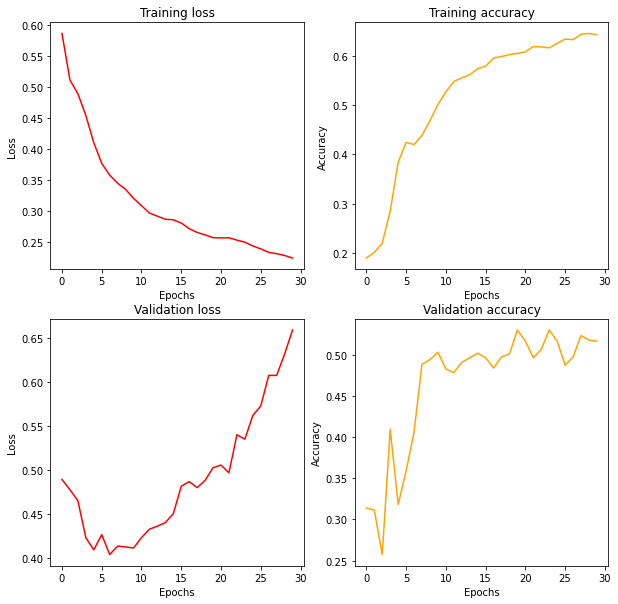

In [20]:
# Đọc các kết quả huấn luyện mô hình qua từng epoch
train_loss, train_acc = history.history['loss'], history.history['accuracy'] # Đọc thông tin loss, acc trên tập train
val_loss, val_acc = history.history['val_loss'], history.history['val_accuracy'] # Đọc thông tin loss, acc trên tập val

plt.figure(figsize=(10, 10)) # Cài đặt kích thước khung ảnh

plt.subplot(2, 2, 1) # Khởi tạo khung ảnh cho training loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Training loss') # Hiển thị title của khung ảnh hiện tại là 'Training Loss'
plt.plot(train_loss, color='red') # Vẽ đường giá trị loss trên tập train qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 2) # Khởi tạo khung ảnh cho training acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Training accuracy') # Hiển thị title của khung ảnh hiện tại là 'Training accuracy'
plt.plot(train_acc, color='orange') # Vẽ đường giá trị accuracy trên tập train qua từng epoch (đường vẽ màu cam)

plt.subplot(2, 2, 3) # Khởi tạo khung ảnh cho val loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Validation loss') # Hiển thị title của khung ảnh hiện tại là 'Validation loss'
plt.plot(val_loss, color='red') # Vẽ đường giá trị loss trên tập val qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 4) # Khởi tạo khung ảnh cho val acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Validation accuracy') # Hiển thị title của khung ảnh hiện tại là 'Validation accuracy'
plt.plot(val_acc, color='orange') # Vẽ đường giá trị accuracy trên tập val qua từng epoch (đường vẽ màu cam)

plt.show() # Hiển thị 4 khung ảnh nhỏ

## **7. Inference**

In [21]:
threshold = 0.4

for text_batch, label_batch in test_ds.take(1):
    for i in range(10):
        input_text = text_batch[i].numpy()
        label = label_batch[i].numpy()
        pred = model.predict(np.expand_dims(input_text, 0), verbose=0)[0]
        threshold_pred = np.where(pred > threshold, 1, 0)
        print(f"Text: {input_text}")
        print(f"Label: {inverse_label(class_lst, label)}")
        print(f"Predicted Label(s): ({inverse_label(class_lst, threshold_pred)})")
        print(" ")

Text: b'adnan__786__ asyounotwish dont worri indian armi way dispatch terrorist hell'
Label: ['anger' 'anticipation' 'optimism' 'trust']
Predicted Label(s): (['disgust' 'fear' 'sadness'])
 
Text: b'academi scienc eschew normal sober tone scientif paper call massiv loss wildlif biolog annihil'
Label: ['disgust']
Predicted Label(s): (['anger' 'joy' 'optimism'])
 
Text: b'blew opportun __ mad'
Label: ['anger' 'disgust' 'sadness']
Predicted Label(s): (['anticipation' 'fear' 'joy' 'optimism'])
 
Text: b'time 2 week 30'
Label: ['joy' 'sadness']
Predicted Label(s): (['sadness'])
 
Text: b'deppress real partner w depress peopl truli dont understand depth affect us add anxieti ampmak wors'
Label: ['fear' 'sadness']
Predicted Label(s): (['disgust' 'pessimism' 'sadness'])
 
Text: b'politicoeurop interest choic word confirm govern fund terror bit open door still'
Label: ['anger' 'disgust' 'fear' 'pessimism']
Predicted Label(s): (['disgust' 'fear'])
 
Text: b'ananavarro cnn sure'
Label: ['joy' 'opt